In [12]:
import pandas as pd
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import torch

In [5]:
data = pd.read_csv('sample dataset.csv')

# Step 2: Preprocess data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W+', ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['processed_text'] = data['title'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
# Step 3: Use LLM for embeddings
# Load pre-trained model and tokenizer
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        embeddings = model(**inputs).last_hidden_state.mean(dim=1)
    return embeddings

data['embeddings'] = data['processed_text'].apply(lambda x: embed_text(x).squeeze().numpy())

# Convert embeddings to a 2D array for clustering
embeddings_matrix = np.vstack(data['embeddings'].values)

In [19]:
# Step 4: Clustering embeddings to find topics
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(embeddings_matrix)

In [20]:
def get_top_keywords(data, clusters, vectorizer, n_terms=10):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()  # Group the TF-IDF vectors by cluster
    terms = vectorizer.get_feature_names_out()
    keywords = []
    for i, r in df.iterrows():
        keywords.append([terms[t] for t in np.argsort(r)[-n_terms:]])
    return keywords

# Create a TF-IDF Vectorizer for the text data
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(data['processed_text'])

# Get the top keywords for each cluster
top_keywords = get_top_keywords(tfidf_matrix, data['cluster'], vectorizer, n_terms=10)

# Print the top keywords for each cluster
for i, keywords in enumerate(top_keywords):
    print(f"Cluster {i}: {', '.join(keywords)}")

Cluster 0: house, trillion, oil, month, year, rate, cut, fed, market, say
Cluster 1: crash, reminder, american, good, cramer, time, day, red, apple, year
Cluster 2: filed, trading, company, file, american, bankruptcy, bank, market, ceo, stock
Cluster 3: bitcoin, bought, musk, amazon, million, worth, buy, new, stock, billion
Cluster 4: spoken, wrong, speaks, market, dip, nice, facebook, na, yes, shape
Cluster 5: investor, time, buy, like, advice, year, investing, think, market, stock
Cluster 6: point, report, year, stock, day, market, employee, hit, plunge, drop
Cluster 7: diligence, perform, discussed, accounting, reddit, buffett, cnbc, market, analysis, stock
Cluster 8: drawing, stock, open, gme, monday, th, week, tuesday, close, market
Cluster 9: expected, market, sale, time, surge, high, growth, tesla, year, stock


In [22]:
print(top_keywords)

[['house', 'trillion', 'oil', 'month', 'year', 'rate', 'cut', 'fed', 'market', 'say'], ['crash', 'reminder', 'american', 'good', 'cramer', 'time', 'day', 'red', 'apple', 'year'], ['filed', 'trading', 'company', 'file', 'american', 'bankruptcy', 'bank', 'market', 'ceo', 'stock'], ['bitcoin', 'bought', 'musk', 'amazon', 'million', 'worth', 'buy', 'new', 'stock', 'billion'], ['spoken', 'wrong', 'speaks', 'market', 'dip', 'nice', 'facebook', 'na', 'yes', 'shape'], ['investor', 'time', 'buy', 'like', 'advice', 'year', 'investing', 'think', 'market', 'stock'], ['point', 'report', 'year', 'stock', 'day', 'market', 'employee', 'hit', 'plunge', 'drop'], ['diligence', 'perform', 'discussed', 'accounting', 'reddit', 'buffett', 'cnbc', 'market', 'analysis', 'stock'], ['drawing', 'stock', 'open', 'gme', 'monday', 'th', 'week', 'tuesday', 'close', 'market'], ['expected', 'market', 'sale', 'time', 'surge', 'high', 'growth', 'tesla', 'year', 'stock']]


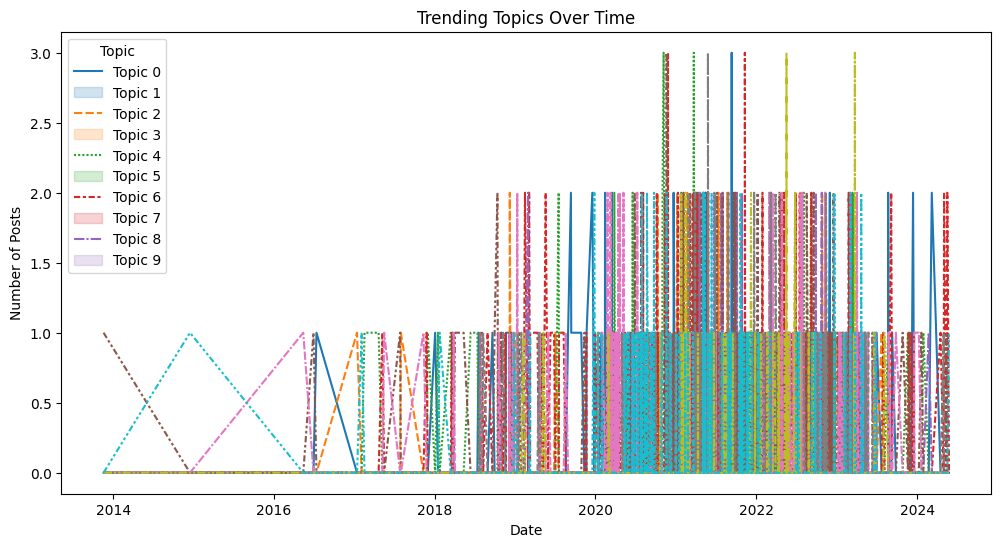

In [21]:
# Step 5: Analyzing trends over time
data['created'] = pd.to_datetime(data['created'])
topic_counts = data.groupby(['created', 'cluster']).size().unstack(fill_value=0)

# Step 6: Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=topic_counts)
plt.title('Trending Topics Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend(title='Topic', loc='upper left', labels=[f'Topic {i}' for i in range(num_clusters)])
plt.show()

In [41]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load the pre-trained GPT-2 model and tokenizer
model_name = "gpt2-medium"  # You can also try "gpt2", "gpt2-large", "gpt2-xl"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Function to generate a topic from a list of words
def generate_topic_from_words(words):
    prompt = f"""Generate a topic that relates the following words: {', '.join(words)}. The topic is: """
    tokens = tokenizer.encode(prompt, return_tensors='pt')

    # Generate text
    outputs = model.generate(
        tokens,
        max_new_tokens=50,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=0.2,
        top_p=0.95,
        top_k=50,
        pad_token_id=tokenizer.eos_token_id
    )

    # Decode the generated text
    topic = tokenizer.decode(outputs[0], skip_special_tokens=True).replace(prompt, "").strip()
    return topic

# List of sets of words
# lists_of_words = [['house', 'trillion', 'oil', 'month', 'year', 'rate', 'cut', 'fed', 'market', 'say'],
#                   ['crash', 'reminder', 'american', 'good', 'cramer', 'time', 'day', 'red', 'apple', 'year'],
#                   ['filed', 'trading', 'company', 'file', 'american', 'bankruptcy', 'bank', 'market', 'ceo', 'stock'],
#                   ['bitcoin', 'bought', 'musk', 'amazon', 'million', 'worth', 'buy', 'new', 'stock', 'billion'],
#                   ['spoken', 'wrong', 'speaks', 'market', 'dip', 'nice', 'facebook', 'na', 'yes', 'shape'],
#                   ['investor', 'time', 'buy', 'like', 'advice', 'year', 'investing', 'think', 'market', 'stock'],
#                   ['point', 'report', 'year', 'stock', 'day', 'market', 'employee', 'hit', 'plunge', 'drop'],
#                   ['diligence', 'perform', 'discussed', 'accounting', 'reddit', 'buffett', 'cnbc', 'market', 'analysis', 'stock'],
#                   ['drawing', 'stock', 'open', 'gme', 'monday', 'th', 'week', 'tuesday', 'close', 'market'],
#                   ['expected', 'market', 'sale', 'time', 'surge', 'high', 'growth', 'tesla', 'year', 'stock']]

# Generate topics for each set of words
generated_topics = []
for words in top_keywords:
    topic = generate_topic_from_words(words)
    generated_topics.append(topic)

# Print generated topics
for i, topic in enumerate(generated_topics):
    # print(f"Generated Topic {i + 1}: {topic}")
    print({topic})


{'"House price index"\nThe topic of the topic: "Tens of trillions of dollars" The subject of topic : "House Price Index" Topic of Topic :   " House Price index " Topic: \xa0 " Tens Of Tr'}
{'_________\n\nThe topic will be created and the user will have to type in the words.\n,,, and will generate a new topic. If you want to generate an existing topic, you can use the same syntax as above.'}
{'"Filed"\nThe topic will be:\n"Trading"  \nThis topic has been created by:\xa0\nhttp://www.filed.com/\nIf you have any questions, please feel free to contact me'}
{'Bitcoin, Buy, Musk.\nThe topic will be:\xa0 Buy Bitcoin, Amazons, Million, Worth, New Stock, Billion.  \nYou can also create a new topic for each of the topics you want to create'}
{'"What is the best way to make money in the internet age?"\nThe topic will be:\xa0 "What are the most important things to know about the Internet?"  \nYou will need to create a new topic and add the words'}
{'"Investor"\nThe topic can be any word that is rel

/home/studio-lab-user/.conda/envs/d2l/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:520: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.92` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Generated Topic 1: . The topics are sorted by date and time (in UTC). You can also filter the list using any of these
Generated Topic 2: You can also create your own topics by clicking on the "Create Topic" button.
Generated Topic 3: - -
Generated Topic 4: . The topics are sorted by price and then the top 10 posts will be added into this list for you
Generated Topic 5: - Create an article about the subject of your choice. You can choose from any topics you want and add links or
Generated Topic 6: . The topics are sorted by date and the order of presentation is as follows (in descending chronological sequence):
Generated Topic 7: . The default value is the current price of that particular asset class in USD (or other currency). You can also
Generated Topic 8: brokerage
Generated Topic 9: - -

...
Generated Topic 10: . The topics are sorted by price and then grouped into categories based on the following criteria (see below):
